In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pulp

### Load data

In [3]:
selection_df = pd.read_pickle('../../data/processed/selection_candidates.pkl')

In [4]:
selection_df.columns

Index(['clean_name', 'lgb_predictions', 'pos', 'value', 'prev_season_total'], dtype='object')

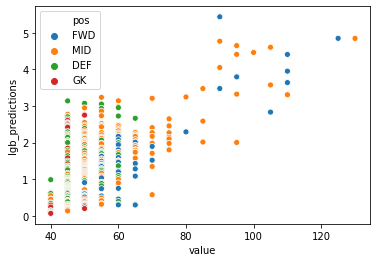

In [5]:
sns.scatterplot(data=selection_df,x='value',y='lgb_predictions',hue='pos')

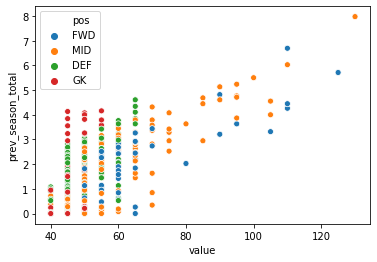

In [6]:
sns.scatterplot(data=selection_df,x='value',y='prev_season_total',hue='pos')

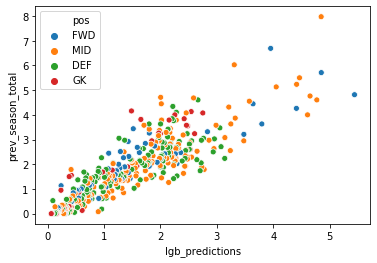

In [7]:
sns.scatterplot(data=selection_df,x='lgb_predictions',y='prev_season_total',hue='pos')

### Select best 15 players

choose highest expected points per game, subject to constraints on total cost, and positions 

note - doesn't capture fact that subs are less valuable (particularly 2nd keeper)

In [8]:
selection_df.columns

Index(['clean_name', 'lgb_predictions', 'pos', 'value', 'prev_season_total'], dtype='object')

removing new-joiners, and manually dropping some guys that moved club

In [9]:
selection_df = selection_df.loc[selection_df.prev_season_total.notna(),:].reset_index(drop=True)

In [10]:
selection_df = selection_df.loc[~selection_df.clean_name.isin(['Xherdan_Shaqiri','Riyad_Mahrez','Thibaut_Courtois']),:]

In [11]:
def select_best_15(data,prediction_col):
    player_ids = [str(i) for i in range(data.shape[0])]

    # Setup
    point = dict(zip(player_ids,data[prediction_col]))
    cost = dict(zip(player_ids,data.value))
    gk = dict(zip(player_ids,(data.pos == 'GK').astype(int)))
    defe = dict(zip(player_ids,(data.pos == 'DEF').astype(int)))
    mid = dict(zip(player_ids,(data.pos == 'MID').astype(int)))
    stri = dict(zip(player_ids,(data.pos == 'FWD').astype(int)))
    
    prob = pulp.LpProblem("Fantasy Football",pulp.LpMaximize)
    player_vars = pulp.LpVariable.dicts("Players",player_ids,0,1,pulp.LpBinary)

    # objective function
    prob += pulp.lpSum([point[i]*player_vars[i] for i in player_ids]), "Total Cost"

    # constraint
    prob += pulp.lpSum([player_vars[i] for i in player_ids]) == 15, "Total 15 Players"
    prob += pulp.lpSum([cost[i] * player_vars[i] for i in player_ids]) <= 1000, "Total Cost"
    prob += pulp.lpSum([gk[i] * player_vars[i] for i in player_ids]) == 2, "2 GK"
    prob += pulp.lpSum([defe[i] * player_vars[i] for i in player_ids]) == 5, "5 DEF"
    prob += pulp.lpSum([mid[i] * player_vars[i] for i in player_ids]) == 5, "5 MID"
    prob += pulp.lpSum([stri[i] * player_vars[i] for i in player_ids]) == 3, "Less than 3 STR"

    # solve
    status = prob.solve()
    
    return status, prob, [int(f.name.replace('Players_','')) for f in prob.variables() if f.varValue == 1 ]

In [12]:
_, _, selections_prev_total = select_best_15(selection_df,'prev_season_total')

In [13]:
_, _, selections_lgb = select_best_15(selection_df,'lgb_predictions')

In [14]:
def show_team(candidates, selection):
    position_map = {'GK':1,'DEF':2,'MID':3,'FWD':4}
    candidates['position_num'] = candidates.pos.map(position_map)
    return candidates.iloc[selection].sort_values(by='position_num').drop(columns='position_num')

In [15]:
selected_prev_total = show_team(selection_df,selections_prev_total); selected_prev_total

,clean_name,lgb_predictions,pos,value,prev_season_total
45,Lukasz_Fabianski,2.545081,GK,45,4.131579
62,Mathew_Ryan,2.420406,GK,45,3.842105
24,Héctor_Bellerín,3.053236,DEF,55,3.473684
38,César_Azpilicueta,2.665145,DEF,65,4.605263
48,Mathias_Jorgensen,2.512884,DEF,45,2.815789
74,Nicolás_Otamendi,2.281822,DEF,65,4.105263
86,Marcos_Alonso,2.220011,DEF,65,4.342105
121,Luka_Milivojevic,2.020095,MID,65,3.789474
137,Fernando_Luiz Rosa,1.967638,MID,55,3.157895
20,Pascal_Groß,3.210916,MID,70,4.315789


In [16]:
selected_lgb = show_team(selection_df,selections_lgb); selected_lgb

,clean_name,lgb_predictions,pos,value,prev_season_total
33,Martin_Dubravka,2.750785,GK,50,4.076923
41,Ben_Foster,2.605418,GK,45,3.236842
22,Cédric_Soares,3.139510,DEF,45,2.236842
23,Ryan_Bertrand,3.073879,DEF,50,2.710526
24,Héctor_Bellerín,3.053236,DEF,55,3.473684
32,Jamaal_Lascelles,2.763227,DEF,50,3.052632
36,Wesley_Hoedt,2.721828,DEF,45,2.055556
19,Ryan_Fraser,3.238199,MID,55,2.552632
27,Jack_Cork,2.948717,MID,50,2.631579
3,Bamidele_Alli,4.770473,MID,90,4.605263
